**done remotely on greenplanet**

In [1]:
import numpy
import gdal
import osr
import glob
import xarray
import datetime
import re
import cartopy
import cmocean
import matplotlib.pyplot as mp
import joblib

list the files in the directory

open all files as a separate gdal dataset  
(store in list)

In [2]:
file_list_all = numpy.array(sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2*.hdf')))

#reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
reg_exp = re.compile('.*h(27|28|29)v(08|09)(.*\.hdf)$') # in this case over Borneo/Sumatra
# shorten list to only have the files you want
file_list_all = numpy.array([filename for filename in file_list_all if re.match(reg_exp, filename)])

In [3]:
file_list_yearday_strings_all = numpy.array([f.split('/')[-1].split('.')[1][1:] for f in file_list_all])
file_list_datetime_all = numpy.array([datetime.datetime.strptime(yd, '%Y%j') for yd in file_list_yearday_strings_all])
yearday_strings_unique_all = numpy.unique(file_list_yearday_strings_all)

#specify which yearday to start and end on, and subset only those
print('goes from',yearday_strings_unique_all[0],'to',yearday_strings_unique_all[-1])
yearday_start = '2001001' #yearday_strings_unique_all[0]
yearday_end = '2018001' #yearday_strings_unique_all[-1]
yearday_start_dt = datetime.datetime.strptime(yearday_start, '%Y%j')
yearday_end_dt = datetime.datetime.strptime(yearday_end, '%Y%j')
yearday_indices = [(i<=yearday_end_dt)&(i>=yearday_start_dt) for i in file_list_datetime_all]

file_list = file_list_all[yearday_indices]
file_list_datetime = file_list_datetime_all[yearday_indices]
file_list_yearday_strings = file_list_yearday_strings_all[yearday_indices]
yearday_strings_unique = numpy.unique(file_list_yearday_strings)

goes from 2000049 to 2018177


create the datetime list you'll iterate over in the data set

In [4]:
datetime_array_subset = numpy.array(([datetime.datetime.strptime(t, '%Y%j') for t in yearday_strings_unique]))

narrow file list even further by choosing only the grid cells that cover Indonesia  
(corresponds to h27/28/29/30/31/32 and v08/09/10)

In [5]:
yearday_strings_unique.size

780

for 8-day data, nothing will be missing

1. Do the first ```yearday``` combo (using ```gdal.BuildVRT```) to get the correct x and y dim sizes

2. Then create a numpy nan array with this dimensionality.  **Make sure it's the length of the full time series, i.e., if you're missing datetimes, keep those in there as nan arrays.**  Create arrays for daytime and nighttime LST *and* the quality control data for them.

3. Loop through each daytime in the list; if it exists, get the hdf files and the data out.  If it doesn't exist, keep the arrays as nans and move on.

note the first yearday_strings_unique option ('2015238') is missing a few tiles...

# parallel processing the modis data

Timing stats  

    n_jobs=6:  
    n_jobs=10:

In [21]:
numpy.save('lst_day_mosaic_ALL_DATA.npy', lst_day_mosaic_ALL_DATA)

In [28]:
lst_day_mosaic_ALL_DATA[lst_day_mosaic_ALL_DATA==0] = numpy.nan

In [32]:
lst_day_mean = numpy.zeros((lst_day_mosaic_ALL_DATA.shape[1:]))
for i in range(lst_day_mosaic_ALL_DATA.shape[1]):
    for j in range(lst_day_mosaic_ALL_DATA.shape[2]):
        lst_day_mean[i,j] = numpy.nanmean(lst_day_mosaic_ALL_DATA[:,i,j])
#lst_day_mean = numpy.nanmean(lst_day_mosaic_ALL_DATA, axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [ ]:
mp.imshow(lst_day_mean); mp.colorbar()

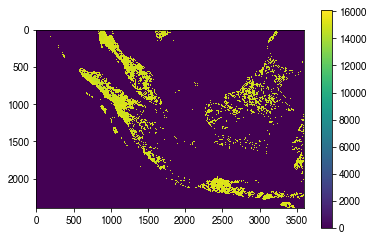

In [27]:
mp.imshow(lst_day_mosaic_ALL_DATA[0,:,:]); mp.colorbar()

# get nino data

In [ ]:
nino34_filename = '/beegfs/DATA/pritchard/blangenb/NINO34_INDEX/nino34_index.txt'
nino34_df = pandas.read_csv(nino34_filename, skiprows=1, skipfooter=3, header=None, delim_whitespace=True)
nino34_data = nino34_df.values[:,1:].flatten()
nino34_data[nino34_data==-99.99]=numpy.nan

In [ ]:
year_start = nino34_df[0].values[0]
year_end = nino34_df[0].values[-1]

nino34_datetime_list = []
for y,m in list(itertools.product(range(year_start,year_end+1),range(1,13))):
    nino34_datetime_list.append(datetime.date(y,m,15))
nino34_datetimes = numpy.array(nino34_datetime_list)

In [ ]:
nino34_data_NaNs = numpy.zeros((nino34_data.shape), dtype=bool)
nino34_data_NaNs[~numpy.isnan(nino34_data)]=1
nino34_data_filtered = nino34_data[nino34_data_NaNs]
nino34_datetimes_filtered = nino34_datetimes[nino34_data_NaNs]

In [ ]:
nino34_data_detrend = scipy.signal.detrend(nino34_data_filtered)
nino34_data_centered = nino34_data_detrend-nino34_data_detrend.mean()

In [ ]:
nino34_data_final = pandas.Series(nino34_data_centered).rolling(window=3, center=True).mean()

In [ ]:
fontsize = 12

fig = mp.figure(figsize=(8.5,2))

x = nino34_datetimes_filtered
y2 = nino34_data_final

ax = fig.add_subplot(111)
ax.plot(x, y2, c='0.1')

ax.axhline(0, lw=0.5, ls='-', c='0.1')
ax.axhline(0.5, lw=1, ls='-', c='firebrick')
ax.axhline(-0.5, lw=1, ls='-', c='dodgerblue')

ax.axhline(1, lw=1, ls='--', c='firebrick')
ax.axhline(-1, lw=1, ls='--', c='dodgerblue')

y1_positive = numpy.ones((nino34_data_final.size))*0.5
y1_negative = numpy.ones((nino34_data_final.size))*-0.5

ax.fill_between(x, y1_positive, y2, where=y2>=y1_positive, color='firebrick', alpha='0.5')
ax.fill_between(x, y1_negative, y2, where=y2<=y1_negative, color='dodgerblue', alpha='0.5')

ax.tick_params(labelsize=fontsize)

In [ ]:
mp.imshow(lst_day_mosaic_ALL_DATA[6,:,:])

In [ ]:
mp.imshow(lst_day_mosaic_data)
#mp.axes().set_xlim(0,7200)

In [ ]:
joblib_result = joblib.Parallel(n_jobs=30, verbose=10)\
(joblib.delayed(interpolate_and_save_calipso_data)(file,xnew,ynew,borneo_main_geom)\
 for file in npy_file_list)

from the documentation:

Atmospheric radiative transfer simulations were made with MODTRAN4 code (Berk et al., 1999) in wide atmospheric and LST conditions: the range of the atmospheric surface temperature (Ts-air) is set as 280–325K for the daytime and 275–305K for the nighttime; the atmospheric column water vapor varies from nearly zero to 5.5cm; and the range of (LST – Ts-air) is set as from 8–29K for daytime LSTs and from −10–4K for nighttime LSTs. A quadratic term of the difference between brightness temperatures in bands 31 and 32 was added into the original viewing angle dependent split-window algorithm in order to improve the LST retrieval accuracy slightly (Wan, 2014).

* valid range 7500-65535 in raw output

In [ ]:
# set data outside valid range equal to nan
lst_day_mosaic_ALL_DATA[(lst_day_mosaic_ALL_DATA<7500)|(lst_day_mosaic_ALL_DATA>65535)] = numpy.nan

# scale it down to Kelvin units
lst_day_mosaic_ALL_DATA_scaled = lst_day_mosaic_ALL_DATA*0.02

# take the time mean
lst_day_mosaic_timemean = numpy.nanmean(lst_day_mosaic_ALL_DATA_scaled, axis=0)

In [ ]:
mp.imshow(lst_day_mosaic_timemean-273.15);mp.colorbar()

In [ ]:
lst_geotrans = lst_day_mosaic.GetGeoTransform()
lst_geotrans

In [ ]:
data_extent = (lst_geotrans[0], \
               lst_geotrans[0] + lst_day_mosaic.RasterXSize*lst_geotrans[1], \
               lst_geotrans[3] + lst_day_mosaic.RasterYSize*lst_geotrans[5], \
               lst_geotrans[3])

In [ ]:
fontsize=12

modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

field = lst_day_mosaic_timemean-273.15

fig = mp.figure(figsize=(4.25,2.75))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=20,vmax=35,cmap=cmocean.cm.matter_r)
ax.coastlines(resolution='10m', color='0.1', lw=0.5)

ax.text(s='MODIS daytime LST (2017)', x=0,y=1.02,
        ha='left', va='bottom', transform=ax.transAxes,
        fontsize=fontsize)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0,axpos.y0-.05,axpos.width,0.05])
cbar = mp.colorbar(image, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\degree$C', fontsize=fontsize)

mp.savefig('../figures/modis_daytime_lst_2017.png', dpi=600, bbox_inches='tight', transparent=True)